In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy
import corner
from IPython.display import display, Math
import pandas as pd
from decimal import Decimal, getcontext
import mpmath as mp


In [2]:
# define useful functions - for now Omg_k is zero

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_L = Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 4 + Omega_lambda
    
    if alpha_tilde == 0:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2)
    
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans


def unitless_time(a , cosmo):
    t = mp.quad(lambda x: 1/(x*E(1/x -1,cosmo)), [0 , a])
    return t

# sound horizon
def r_s_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return mp.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2)*x))), [a_min, 1/(1+z)])

# particle horizon
def r_hor_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return mp.quad(lambda x: 1/((x**2)*E(1/x-1, cosmo)), [a_min, 1/(1+z)])

# Used to find z_CMB
def g1(wb):
    return (0.0783*wb**(-0.238))/(1 + 39.5*wb**(0.763))

# Used to find z_CMB
def g2(wb):
    return 0.56/(1 + 21.1*wb**(1.81))

# redshift at which the BB occurs
def z_CMB(Omg_b,Omg_m,h):
    wb = Omg_b * h**2
    wm = Omg_m * h**2
    return 1048*(1+0.00124*wb**(-0.738))*\
           (1 + g1(wb)*wm**g2(wb))

# Used to find r_s
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

# Shift parameter
def R(cosmo,h):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    return np.sqrt(Omg_m)*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]

# Acoustic scale
def l_A(cosmo,h):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    return np.pi*scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z_CMB(Omg_b,Omg_m,h))[0]/\
           (scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2)*x))), 1e-2, 1/(1+z_CMB(Omg_b,Omg_m,h)))[0])

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


In [4]:
# try some values
cosmotry = [0.0453,0.027,0,9.227e-5,1e-20,0]
cosmotry_LCDM = [0.0453,0.027,0,9.227e-5,0,0]
h = 0.67
z_CMB_val = z_CMB(cosmotry[1],(cosmotry[0]+cosmotry[1]),h)
R_data = 1.74963 #\pm 5e-3 (assume no cross correlation - false)
l_a_data = 301.80845 #\pm 0.09
a_min = 0
mp.mp.dps = 3000

#print(r_s_fracH0c(z_CMB_val, cosmotry, a_min))
#print(np.pi*R_data/(l_a_data*np.sqrt(cosmotry[0]+cosmotry[1])))

In [6]:
#print(r_hor_fracH0c(z_CMB_val,cosmotry_LCDM, 0))
alim = 0 # approx planck scales
#print(r_hor_fracH0c(z_CMB_val,cosmotry, alim))
#print(r_hor_fracH0c(0,cosmotry, alim))
val = r_hor_fracH0c(z_CMB_val,cosmotry, alim)/(
    r_hor_fracH0c(0,cosmotry, alim) - r_hor_fracH0c(z_CMB_val,cosmotry, alim))
#print(val*180/np.pi)

KeyboardInterrupt: 

In [8]:
a_LCDM = np.linspace(1e-20,1e-1, int(1e3))
a = np.linspace(2e-9,1e-1, int(1e3))

r_horizon_LCDM = np.zeros(len(a))
r_horizon = np.zeros(len(a))

for i in range(len(a)):
    r_horizon[i] = r_hor_fracH0c(1/a[i] - 1 , cosmotry, 1e-9)
    r_horizon_LCDM[i] = r_hor_fracH0c(1/a_LCDM[i] - 1,cosmotry_LCDM, 0)


KeyboardInterrupt: 

In [ ]:
plt.plot(a_LCDM,r_horizon_LCDM, label = "LCDM")
plt.plot(a,r_horizon, label = "4DEGB")
#plt.plot(np.ones(int(1e2)), np.linspace(np.min(r_horizon),np.max(r_horizon), int(1e2)), "k--", label = "today")

plt.xlabel("a")
plt.ylabel("particle horizon")
plt.legend()

In [ ]:
# Set the desired precision of Decimal
getcontext().prec = 120
alpha_t = Decimal('1e-43')
cosmotry = [Decimal('0.0453'),Decimal('0.027'),Decimal('0'),Decimal('9.227e-5'),alpha_t,Decimal('0')]
cosmotry_LCDM = [Decimal('0.0453'),Decimal('0.027'),Decimal('0'),Decimal('9.227e-5'),Decimal('0'),Decimal('0')]
    
a = np.logspace(-53,-1, int(1e3),dtype=np.dtype(Decimal))
for i in range(len(a)):
    a[i] = Decimal(a[i])

plt.plot((alpha_t)**(Decimal('0.25'))*np.ones(len(a[int(3*idx_a_e/4):]),dtype=np.dtype(Decimal)), \
         Decimal('3e3')/(a[int(3*idx_a_e/4):]*E(1/a[int(3*idx_a_e/4):] - 1 , cosmotry_LCDM)), "k--")

idx_a_e = find_nearest_idx(a, (alpha_t)**(Decimal('0.25')))

plt.plot(a, Decimal('3e3')/(a*E(1/a - 1 , cosmotry)))

print([idx_a_e])
plt.plot(a[:idx_a_e], Decimal('3e3')/(E(1/a[idx_a_e] - 1 , cosmotry_LCDM)) * 1/a[:idx_a_e])
plt.plot(a[idx_a_e:], Decimal('3e3')/(a[idx_a_e:]*E(1/a[idx_a_e:] - 1 , cosmotry_LCDM)))
plt.plot(a[int(3*idx_a_e/4):idx_a_e], Decimal('3e3')/(a[int(3*idx_a_e/4):idx_a_e]*E(1/a[int(3*idx_a_e/4):idx_a_e] - 1 , cosmotry_LCDM)))

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-53,1e-1)
plt.xlabel("scale factor a")
plt.ylabel(r"$(aH)^{-1} [h^{-1}$Mpc]")

[480]


Text(0, 0.5, '$(aH)^{-1} [h^{-1}$Mpc]')

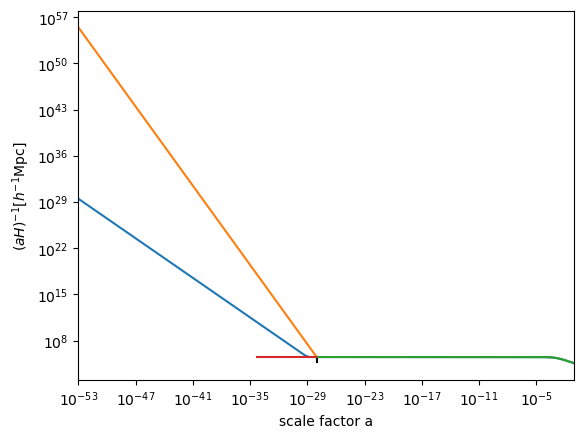

In [125]:
# Set the desired precision of Decimal
getcontext().prec = 120
alpha_t = Decimal('1e-112')
cosmotry = [Decimal('0.0453'),Decimal('0.027'),Decimal('0'),Decimal('9.227e-5'),alpha_t,Decimal('0')]
cosmotry_LCDM = [Decimal('0.0453'),Decimal('0.027'),Decimal('0'),Decimal('9.227e-5'),Decimal('0'),Decimal('0')]
    
a = np.logspace(-53,-1, int(1e3),dtype=np.dtype(Decimal))
for i in range(len(a)):
    a[i] = Decimal(a[i])

plt.plot((alpha_t)**(Decimal('0.25'))*np.ones(len(a[int(3*idx_a_e/4):]),dtype=np.dtype(Decimal)), \
         Decimal('3e3')/(a[int(3*idx_a_e/4):]**2*E(1/a[int(3*idx_a_e/4):] - 1 , cosmotry_LCDM)), "k--")

idx_a_e = find_nearest_idx(a, (alpha_t)**(Decimal('0.25')))

plt.plot(a, Decimal('3e3')/(a**2*E(1/a - 1 , cosmotry)))

print([idx_a_e])
plt.plot(a[:idx_a_e], Decimal('3e3')/(E(1/a[idx_a_e] - 1 , cosmotry_LCDM)) * 1/a[:idx_a_e]**2)
plt.plot(a[idx_a_e:], Decimal('3e3')/(a[idx_a_e:]**2*E(1/a[idx_a_e:] - 1 , cosmotry_LCDM)))
plt.plot(a[int(3*idx_a_e/4):idx_a_e], Decimal('3e3')/(a[int(3*idx_a_e/4):idx_a_e]**2*E(1/a[int(3*idx_a_e/4):idx_a_e] - 1 , cosmotry_LCDM)))

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-53,1e-1)
plt.xlabel("scale factor a")
plt.ylabel(r"$(aH)^{-1} [h^{-1}$Mpc]")

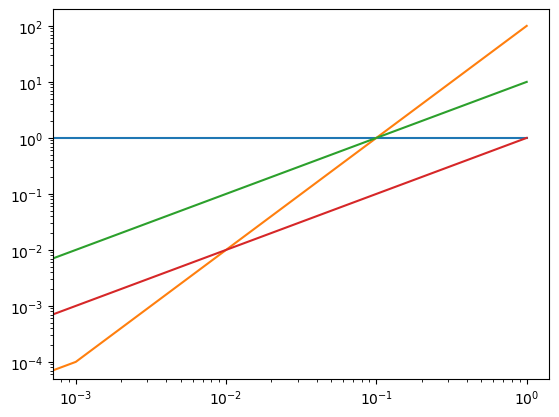

In [23]:
a_test = np.linspace(0,1,int(1e3))
plt.plot(a_test, np.ones(len(a_test)))
plt.plot(a_test, 100*a_test**2)
plt.plot(a_test, 10*a_test)
plt.plot(a_test, a_test)

plt.xscale("log")
plt.yscale("log")

In [26]:
# find Planck scale factor from planck time
Omg_rad = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5

mp.mp.dps = 100

cosmo1 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-15, 0]
cosmo2 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-36, 0]
cosmo3 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-43, 0]
cosmoLCDM = [0.264 , 0.0493 , 0 , Omg_rad, 0, 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t

a_tofindtime = np.logspace(-70,-50, int(5e2))
t_planck = 5.391247e-44 #s
t_planck = t_planck * 67/(3.086e22) # unitless
print(t_planck)
t_array1 = np.zeros(len(a_tofindtime))
t_array2 = np.zeros(len(a_tofindtime))
t_array3 = np.zeros(len(a_tofindtime))
for i in range(len(a_tofindtime)):
    t_array1[i] = unitless_time(a_tofindtime[i] , cosmo1)
    t_array2[i] = unitless_time(a_tofindtime[i] , cosmo2)
    t_array3[i] = unitless_time(a_tofindtime[i] , cosmo3)
a_planck1 = a_tofindtime[find_nearest(t_array1, t_planck)]
a_planck2 = a_tofindtime[find_nearest(t_array2, t_planck)]
a_planck3 = a_tofindtime[find_nearest(t_array3, t_planck)]
print(a_planck3)
print("error in planck time during calculations = ", (t_array1[find_nearest(t_array1, t_planck)]-t_planck)/t_planck)
print("error in planck time during calculations = ", (t_array3[find_nearest(t_array3, t_planck)]-t_planck)/t_planck)

1.1704910855476345e-64
7.442922330043758e-55
error in planck time during calculations =  -0.02051693476683303
error in planck time during calculations =  0.011637658655744948


In [ ]:
Omg_rad = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5

cosmoLarge = [0.264 , 0.0493 , 0 , Omg_rad, 1e-43, 0]

mp.mp.dps = 10000
amin = 1e-1000
amin2 = 1e-10000


#print(r_hor_fracH0c(1100,cosmoLarge, amin))
#print(r_hor_fracH0c(0,cosmoLarge, amin))
print("%.2f" % float(r_hor_fracH0c(1100,cosmoLarge, amin)/(r_hor_fracH0c(0,cosmoLarge, amin)-r_hor_fracH0c(1100,cosmoLarge, amin))))
print("%.2f" % float(r_hor_fracH0c(1100,cosmoLarge, amin2)/(r_hor_fracH0c(0,cosmoLarge, amin2)-r_hor_fracH0c(1100,cosmoLarge, amin2))))

#print(r_hor_fracH0c(1100,cosmoLCDM, a_planck3))
#print(r_hor_fracH0c(0,cosmoLCDM, a_planck3))
#print(r_hor_fracH0c(1100,cosmoLCDM, a_planck3)/(r_hor_fracH0c(0,cosmoLCDM, a_planck3)-r_hor_fracH0c(1100,cosmoLCDM, a_planck3)))

In [16]:
# find Planck scale factor from planck time
Omg_rad = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5

mp.mp.dps = 100

alpha_C = np.logspace(-43,-7, 20)
cosmoLCDM = [0.264 , 0.0493 , 0 , Omg_rad, 0, 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t

a_tofindtime = np.logspace(-70,-50, int(5e2))
t_planck = 5.391247e-44 #s
t_planck = t_planck * 67/(3.086e22) # unitless
print(t_planck)

t_array = np.zeros(len(a_tofindtime))
theta_hor_p = np.zeros(len(alpha_C))

for i in range(len(alpha_C)):
    for j in range(len(a_tofindtime)):
        t_array[j] = unitless_time(a_tofindtime[j] , [0.264 , 0.0493 , 0 , Omg_rad, alpha_C[i], 0])
    
    a_planck = a_tofindtime[find_nearest(t_array, t_planck)]
    cosmo_i = [0.264 , 0.0493 , 0 , Omg_rad, alpha_C[i], 0]
    
    theta_hor_p[i] = r_hor_fracH0c(1100,cosmo_i, a_planck)/(r_hor_fracH0c(0,cosmo_i, a_planck)-r_hor_fracH0c(1100,cosmo_i, a_planck))


1.1704910855476345e-64


In [ ]:
# find Planck scale factor from planck time
Omg_rad = (1 + (7/8) * (4/11)**(4/3)*3.046)*9.227e-5

mp.mp.dps = 1000

alpha_C = np.logspace(-43,-7, 20)
cosmoLCDM = [0.264 , 0.0493 , 0 , Omg_rad, 0, 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t

a_min = np.logspace(-1000,-40, int(10))

theta_hor = np.zeros((len(a_min),len(alpha_C)))

for i in range(len(alpha_C)):
    cosmo_i = [0.264 , 0.0493 , 0 , Omg_rad, alpha_C[i], 0]
    for k in range(len(a_min)):    
        theta_hor[k][i] = r_hor_fracH0c(1100,cosmo_i, a_min[k])/(r_hor_fracH0c(0,cosmo_i, a_min[k])-r_hor_fracH0c(1100,cosmo_i, a_min[k]))
    print(i)

0
1
2
3
4
5
6
7
8
9
10


2.811768697974214e-29


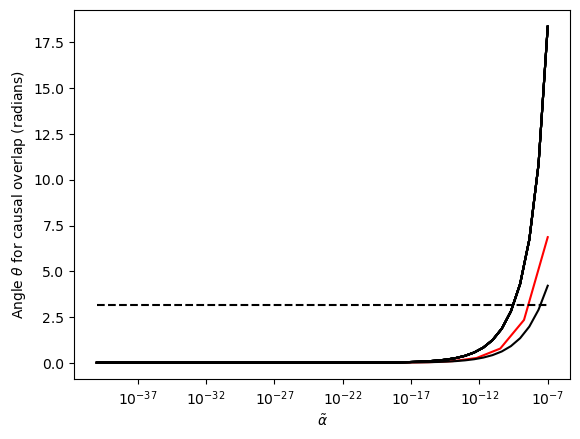

In [32]:
#print(theta_hor)
plt.plot(alpha_C,theta_hor_p, color="r")
for i in range(len(theta_hor)):
    plt.plot(alpha_C,theta_hor[i], "k")
plt.xscale("log")
plt.plot([1e-40,1e-7],[3.14,3.14], "k--")
print(alpha_C[find_nearest(theta_hor_p,1)])
#plt.xlim(1e-40,1e-7)
plt.ylabel(r"Angle $\theta$ for causal overlap (radians)")
plt.xlabel(r"$\tilde{\alpha}$")
plt.savefig("Planck_cutoff_horizon")

In [4]:
'''Plots of Sound Horizon'''

mp.mp.dps = 100
h = 0.67

#Find quantities
a1 = np.logspace(a_planck1,1.0, int(5e2))
a2 = np.logspace(a_planck2,1.0, int(5e2))
a3 = np.logspace(a_planck3,1.0, int(5e2))

r_s_LCDM1 = np.zeros(len(a1))
r_s_LCDM2 = np.zeros(len(a2))
r_s_LCDM3 = np.zeros(len(a3))
r_s1 = np.zeros(len(a1))
r_s2 = np.zeros(len(a2))
r_s3 = np.zeros(len(a3))

for i in range(len(a1)):
    r_s_LCDM1[i] = r_s_fracH0c(1/a1[i] - 1,cosmoLCDM, 0) #nucleosynthesis a_min = 2.5e-9
    r_s_LCDM2[i] = r_s_fracH0c(1/a2[i] - 1,cosmoLCDM, 0)
    r_s_LCDM3[i] = r_s_fracH0c(1/a3[i] - 1,cosmoLCDM, 0)
    r_s1[i] = r_s_fracH0c(1/a1[i] - 1 , cosmo1, a_planck1)
    r_s2[i] = r_s_fracH0c(1/a2[i] - 1 , cosmo2, a_planck2)
    r_s3[i] = r_s_fracH0c(1/a3[i] - 1 , cosmo3, a_planck3)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

7.20635132129306e-62


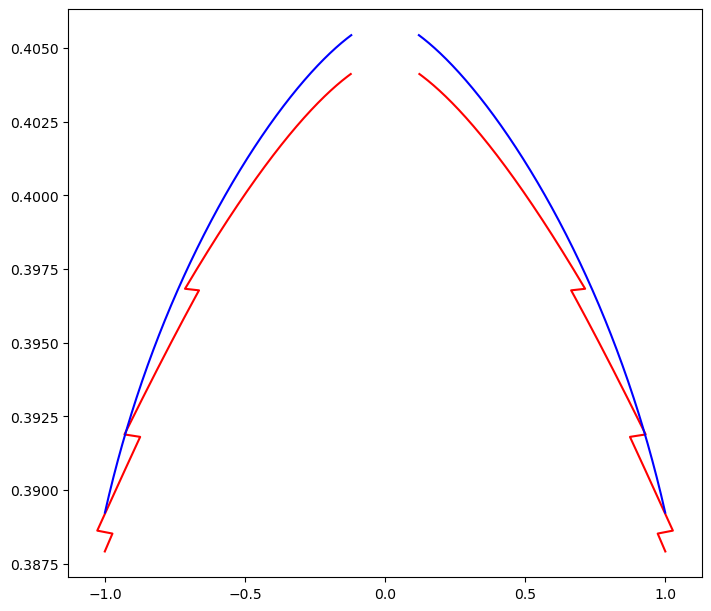

In [7]:
# Check horizon problem solution if cutoff scale is planck scale
fig = plt.figure(constrained_layout=True,figsize=(7,6))
ax = plt.axes()

indx_CMB = find_nearest(a1, 1/1101)

#4DEGB
#ax.plot(r_s1_new-r_s1_new[idx_today],r_s1_new, label = "light cone", color = col[2])
#ax.plot(-r_s1_new+r_s1_new[idx_today],r_s1_new, label = "light cone", color = col[2])
ax.plot(1/(a1*E(1/a1 - 1 , cosmo1)),r_s1, label = "hubble sphere", color = "r")
ax.plot(-1/(a1*E(1/a1 - 1 , cosmo1)),r_s1, label = "hubble sphere", color = "r")

ax.plot(1/(a1*E(1/a1 - 1 , cosmoLCDM)),r_s_LCDM1+0.12, label = "hubble sphere", color = "b")
ax.plot(-1/(a1*E(1/a1 - 1 , cosmoLCDM)),r_s_LCDM1+0.12, label = "hubble sphere", color = "b")

#ax.plot(-r_s1_new[:indx_CMB_new]-r_s1_new[idx_today]+2*r_s1_new[indx_CMB_new],r_s1_new[:indx_CMB_new], label = "light cone", color = col[2])
#ax.plot(r_s1_new[:indx_CMB_new]+r_s1_new[idx_today]-2*r_s1_new[indx_CMB_new],r_s1_new[:indx_CMB_new], label = "light cone", color = col[2])

#filled areas
"""
ax.fill_between([r_s1_new[indx_LCDM]+r_s1_new[idx_today]-2*r_s1_new[indx_CMB_new], r_s1_new[idx_today]-r_s1_new[indx_CMB_new],\
                 -r_s1_new[indx_LCDM]+r_s1_new[idx_today]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_CMB_new],r_s1_new[indx_LCDM]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_LCDM],r_s1_new[indx_LCDM]],color=lighten_color("b", 1.5), alpha=0.1)
ax.fill_between([-r_s1_new[indx_LCDM]-r_s1_new[idx_today]+2*r_s1_new[indx_CMB_new],-r_s1_new[idx_today]+r_s1_new[indx_CMB_new],\
                 r_s1_new[indx_LCDM]-r_s1_new[idx_today]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_CMB_new],r_s1_new[indx_LCDM]],
                [r_s1_new[indx_LCDM],r_s1_new[indx_LCDM],r_s1_new[indx_LCDM]],color=lighten_color("b", 1.5), alpha=0.1)

"""
# Times
#ax.plot([-1,1],[r_s1[indx_CMB],r_s1[indx_CMB]],"k--")
#ax.plot([-1,1],[r_s1[0],r_s1[0]],"k--")
#ax.plot([-1,1],[0.12,0.12],"k--")
print(a_planck1)
#ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[idx_today], "k--")
#ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*(r_s1_new[indx_CMB_new]), "k--")
#ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[indx_reheating], "k--")

plt.show()